# Przygotowywanie danych

### Pobieranie bazy danych

In [ ]:
#instalacja pakietu gdown
!pip install -U --no-cache-dir gdown==4.6.0 --pre
#usuwanie i tworzenie pustego katalogu data
!rm -rf data && mkdir data
#pobieranie zip-a ze zdjęciami
!gdown 166dEFXpIVEbmbqWhTGhQgWSuT6j-12MN -O data.zip
#rozpakowywanie pliku data.zip do katalogu data
!unzip -q data.zip -d data

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0
Downloading...
From: https://drive.google.com/uc?id=166dEFXpIVEbmbqWhTGhQgWSuT6j-12MN
To: /content/data.zip
100% 126M/126M [00:02<00:00, 51.2MB/s]


### Importowanie niezbędnych bibliotek

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

## Badanie zawartości bazy danych

### Weryfikowanie wielkości bazy danych  

In [ ]:
image_count = len(list(glob.glob('data/**/**/*.jpg')))
print(f'{image_count} examples of different sports')

934 examples of different sports


### Weryfikowanie rozkładu klas w bazie danych  

In [ ]:
volleyball_count = len(list(glob.glob('data/**/volleyball/*.jpg')))
football_count = len(list(glob.glob('data/**/football/*.jpg')))
rugby_count = len(list(glob.glob('data/**/rugby/*.jpg')))
swimming_count = len(list(glob.glob('data/**/swimming/*.jpg')))
golf_count = len(list(glob.glob('data/**/golf/*.jpg')))
print(f'{volleyball_count} examples of volleyball and {football_count} football and {rugby_count} rugby and {swimming_count} swimming and {golf_count} golf   to train')

165 examples of volleyball and 221 football and 191 rugby and 179 swimming and 178 golf   to train


### Wyświetlanie przykładowych zdjęć

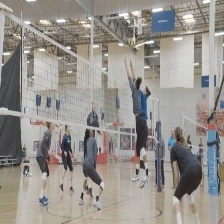

In [ ]:
volleyballs = list(glob.glob('data/train/volleyball/*'))
PIL.Image.open(str(volleyballs[33]))

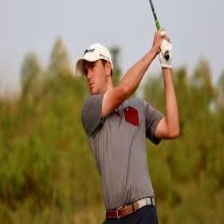

In [ ]:
golfs = list(glob.glob('data/train/golf/*'))
PIL.Image.open(str(golfs[42]))

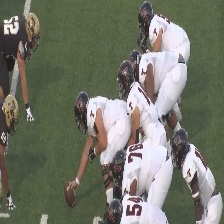

In [ ]:
footballs = list(glob.glob('data/train/football/*'))
PIL.Image.open(str(footballs[77]))

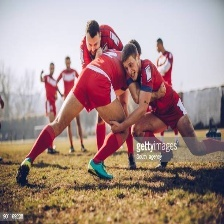

In [ ]:
rugbys = list(glob.glob('data/train/rugby/*'))
PIL.Image.open(str(rugbys[66]))

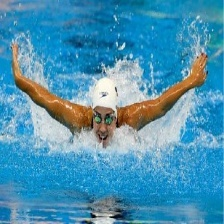

In [ ]:
swimmings = list(glob.glob('data/train/swimming/*'))
PIL.Image.open(str(swimmings[12]))

# Trenowanie modelu sieci neuronowej

### Zmienne niezbędne do trenowania modelu

In [ ]:
batch_size = 32
class_count = 5

img_height = 64
img_width = 64

### Ładowanie bazy danych wykorzystywanej do trenowania modelu

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data/train',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 813 files belonging to 5 classes.


### Ładowanie bazy danych wykorzystywanej do testowania wydajności modelu podczas uczenia

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  'data/test',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 124 files belonging to 5 classes.


### Wyświetlenie nazwy klas występujących w bazie danych

In [ ]:
class_names = train_ds.class_names
print(f'class names: {class_names}')

class names: ['football', 'golf', 'rugby', 'swimming', 'volleyball']


Drobne ustawienia optymalizacyjne

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Tworzenie struktury modelu sieci neuronowej

In [ ]:
def get_model(type='custom'):
  model = None
  if type == 'resnet_transfer':
    base_model = tf.keras.applications.ResNet50(
            include_top=False,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )
    x = layers.GlobalAveragePooling2D()(base_model.output)

    # Add a fully connected layer with a sigmoid activation for binary classification
    predictions = layers.Dense(class_count, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

  elif type == 'resnet':
    model = tf.keras.applications.ResNet50(
            weights=None,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )

  elif type == 'custom':
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(class_count)
    ])

  return model


### Kompilowanie modelu oraz wyświetlanie jego struktury

In [ ]:
model = get_model('custom')
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 548,645 (2.09 MB)

 Trainable params: 548,645 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

### Uruchomienie procesu trenowania

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - accuracy: 0.2909 - loss: 1.5385 - val_accuracy: 0.4274 - val_loss: 1.5704
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4812 - loss: 1.2187 - val_accuracy: 0.5887 - val_loss: 0.9037
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6460 - loss: 0.8517 - val_accuracy: 0.6935 - val_loss: 0.7237
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7227 - loss: 0.7184 - val_accuracy: 0.5968 - val_loss: 0.9335
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7662 - loss: 0.6384 - val_accuracy: 0.7177 - val_loss: 0.7614
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7709 - loss: 0.5705 - val_accuracy: 0.6694 - val_loss: 0.8629
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7983 - loss: 0.5627 - val_accuracy: 0.6694 - val_loss: 0.7506
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8416 - loss: 0.4315 - val_accuracy: 0.7258 - val_lo

# Ocena wytrenowanego modelu

### Wyświetlenie przebiegu procesu trenowania

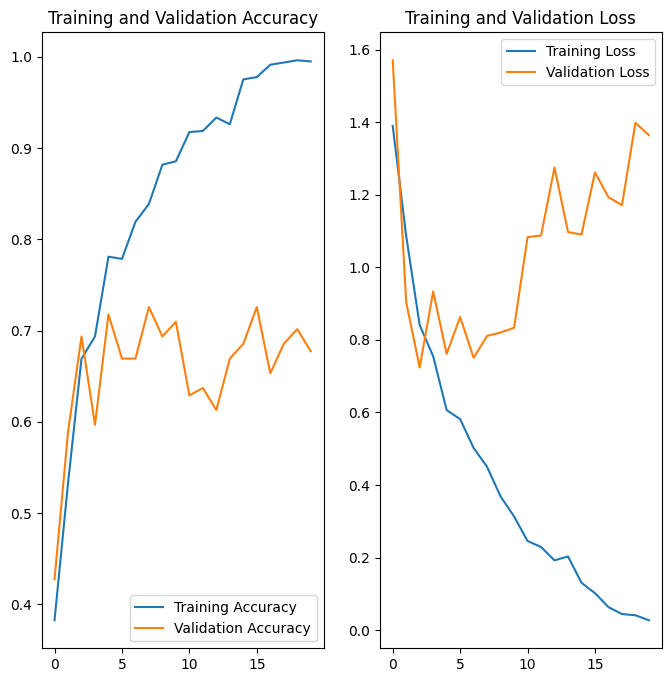

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Raport dotyczący jakości klasyfikacji

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(val_ds, model):
    y_pred = []
    y_true = []

    for batch_images, batch_labels in val_ds:
        predictions = model.predict(batch_images, verbose=0)
        y_pred = y_pred + np.argmax(tf.nn.softmax(predictions), axis=1).tolist()
        y_true = y_true + batch_labels.numpy().tolist()

    cm = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred, target_names=class_names))
    print(cm)

    return cm

cm = evaluate_model(val_ds, model)

              precision    recall  f1-score   support

    football       0.52      0.43      0.47        30
        golf       0.72      0.86      0.78        21
       rugby       0.41      0.52      0.46        25
    swimming       1.00      0.96      0.98        24
  volleyball       0.89      0.71      0.79        24

    accuracy                           0.68       124
   macro avg       0.71      0.70      0.70       124
weighted avg       0.70      0.68      0.68       124

[[13  0 16  0  1]
 [ 2 18  1  0  0]
 [ 7  5 13  0  0]
 [ 0  0  0 23  1]
 [ 3  2  2  0 17]]


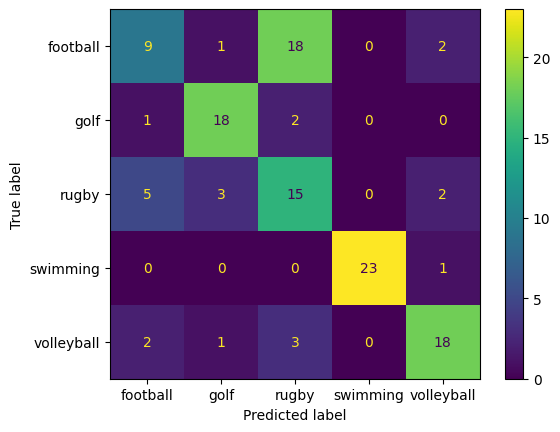

In [ ]:
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

Zbior danych w duzej czesci pozyskany z:


*   https://www.kaggle.com/datasets/gpiosenka/sports-classification

